<a href="https://colab.research.google.com/github/pda-sedano/quantum_computing_research/blob/main/chsh_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Restarts kernel
# From comment on https://stackoverflow.com/a/64356932/7233512
# import os
# os._exit(00)

In [1]:
# Installs missing packages
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136818 sha256=6dcff7db1facf54d128191dcd8cb843d8564152da89d6530c6eaed2b91c5d245
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc55

In [2]:
import math
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [3]:
win_message = 'Yay!! You win!'
lose_message = 'Awww... you lose :('

def chsh_game(send_to_alice, send_to_bob, get_output_bits, verbose=False):
    # choose bits at random
    x, y = np.random.randint(2, size=2)

    send_to_alice(x)
    send_to_bob(y)

    a, b = get_output_bits()

    won = (a ^ b) == (x & y)

    if verbose:
        print(win_message if won else lose_message)

    return won

In [4]:
bits = [0, 0]

def get_output_bits():
    return bits

def get_result(bit, index):
    print(f'The referee has given you the bit {bit}')

    while True:
        result = input('Enter 0 or 1: ')

        if result == '0' or result == '1':
            bits[index] = int(result)
            break

        print('Invalid input, please try again.')

In [5]:

chsh_game(lambda x : get_result(x, 0), lambda y : get_result(y, 1), get_output_bits, True)

The referee has given you the bit 1
Enter 0 or 1: 0
The referee has given you the bit 0
Enter 0 or 1: sdfsdf
Invalid input, please try again.
Enter 0 or 1: np
Invalid input, please try again.
Enter 0 or 1: 1.0
Invalid input, please try again.
Enter 0 or 1: 1
Awww... you lose :(


False

In [6]:
# optimal classical strategy (always output the same) - 75% win rate
number_of_trials = 1000
number_of_wins = 0

for i in range(number_of_trials):
    number_of_wins += chsh_game(lambda x : x, lambda y : y, lambda : (1, 1))

print(f'Win rate: {number_of_wins / number_of_trials}')

Win rate: 0.772


In [7]:
# Optimal quantum strategy - approx. 85% win rate
simulator = AerSimulator()

# Determines which basis to measure in
def add_measurement(qubit, setting):
    if qubit == 0:
        # TODO: Determine why this doesn't work
        #if setting:
         #   circuit.h(0)
        circuit.ry(setting * math.tau / 4, 0)

    if qubit == 1:
        circuit.ry((-1) ** setting * math.tau / 8, 1)

def get_output_bits():
    circuit.measure([0, 1], [0, 1]) # measure qubit at index and store result in classical bit

    # Run simulation
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=1)
    result = job.result()
    counts = result.get_counts(compiled_circuit)
    bits = counts.most_frequent()

    return [int(bit) for bit in bits]

# Simulate CHSH game
number_of_trials = 1000
number_of_wins = 0

for i in range(number_of_trials):
    circuit = QuantumCircuit(2, 2) # 2 qubits, 2 classical bits

    # Prepare Bell state
    circuit.h(0) # Add Hadamard gate at qubit 0
    circuit.cx(0, 1) # Add CNOT gate with qubit 0 as control qubit and qubit 1 as target qubit

    number_of_wins += chsh_game(lambda x : add_measurement(0, x), lambda y : add_measurement(1, y),
                                get_output_bits)

print(f'Win rate: {number_of_wins / number_of_trials}')

Win rate: 0.835


/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


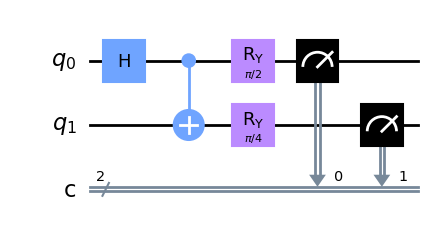

In [8]:
circuit.draw('mpl')